In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('data/data.csv')
data.head()

,id,image_path,openimages_id,source_url,a16_race,a17_color,a1_age_approx,a2_weight_approx,a4_gender,a6_hair_color,...,a37_receipt,a74_address_current_complete,a31_passport,a33_student_id,a78_address_home_complete,a99_legal_involvement,a30_credit_card,a92_email_content,a13_full_nudity,dataset
0,2017_79418867,images/val2017/2017_79418867.jpg,8ccc41d3b3580a83,https://farm4.staticflickr.com/307/19673416731...,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,validation
1,2017_12900557,images/val2017/2017_12900557.jpg,ecb8db2c9b1b9255,https://farm6.staticflickr.com/5336/9124532147...,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,validation
2,2017_66855135,images/val2017/2017_66855135.jpg,2d8c51e27c11db9d,https://c7.staticflickr.com/6/5609/15732582651...,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,validation
3,2017_87810944,images/val2017/2017_87810944.jpg,f15b7c6bea8327bd,https://c6.staticflickr.com/3/2924/14034028782...,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,validation
4,2017_44476364,images/val2017/2017_44476364.jpg,364dc392e685ef64,https://farm5.staticflickr.com/2869/9041112978...,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,validation


In [3]:
data.dataset.unique()

array(['validation', 'test', 'train'], dtype=object)

In [4]:
train = data.loc[data['dataset'] == 'train']
val = data.loc[data['dataset'] == 'validation']
test = data.loc[data['dataset'] == 'test']

In [5]:
print(f"Train size:{len(train)}\n"
      f"Validation size:{len(val)}\n"
      f"Test size:{len(val)}")

Train size:10000
Validation size:4167
Test size:4167


**Train analysis**

In [6]:
attr = train.columns[4:-1]

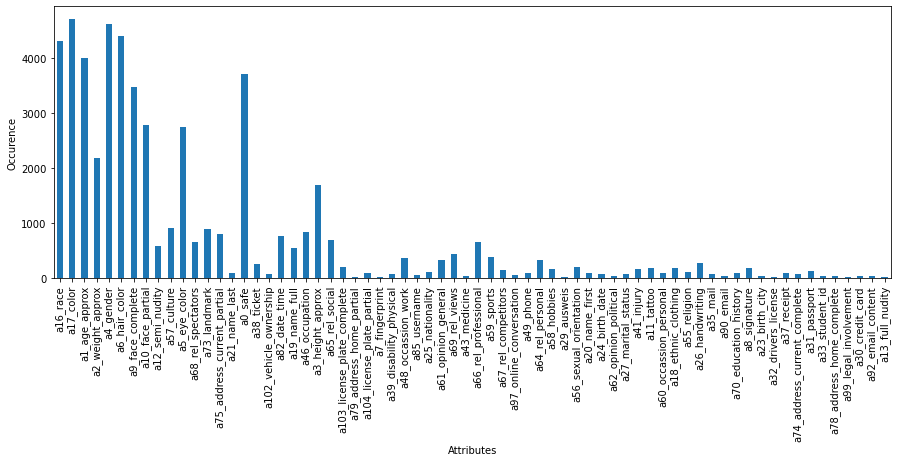

In [7]:
counts=train[attr].sum(axis=0) # occurence counts
ax = counts.plot.bar(figsize=(15,5));
ax.set_xlabel("Attributes");
ax.set_ylabel("Occurence");

In [8]:
tuples = list(zip(attr,train[attr].sum().to_numpy()))

In [9]:
disp = pd.DataFrame(tuples,columns=['attributes','count'])
disp

,attributes,count
0,a16_race,4321
1,a17_color,4710
2,a1_age_approx,3998
3,a2_weight_approx,2193
4,a4_gender,4625
...,...,...
63,a78_address_home_complete,41
64,a99_legal_involvement,22
65,a30_credit_card,46
66,a92_email_content,30


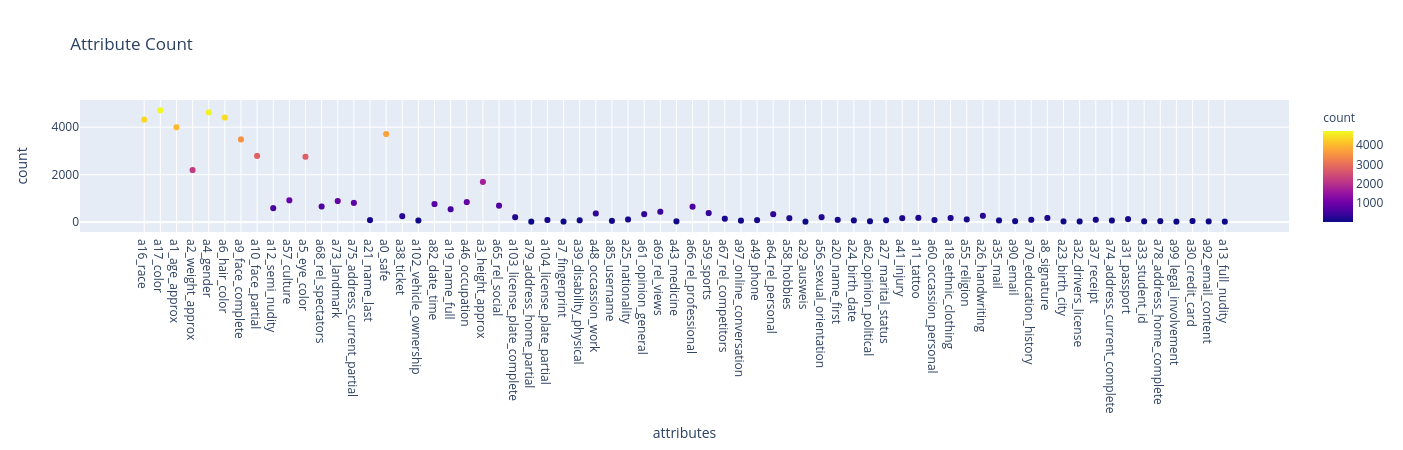

In [13]:
import plotly.express as px
fig = px.scatter(disp, y="count", x="attributes", title='Attribute Count', color='count')
fig.show()

In [14]:
freq=(train[attr].sum(axis=0)/len(train))*100
freq

a16_race                     43.21
a17_color                    47.10
a1_age_approx                39.98
a2_weight_approx             21.93
a4_gender                    46.25
                             ...  
a78_address_home_complete     0.41
a99_legal_involvement         0.22
a30_credit_card               0.46
a92_email_content             0.30
a13_full_nudity               0.21
Length: 68, dtype: float64

In [1]:
matrix = train[attr].astype(int)
co_matrix = matrix.T.dot(matrix)
co_matrix

NameError: name 'train' is not defined

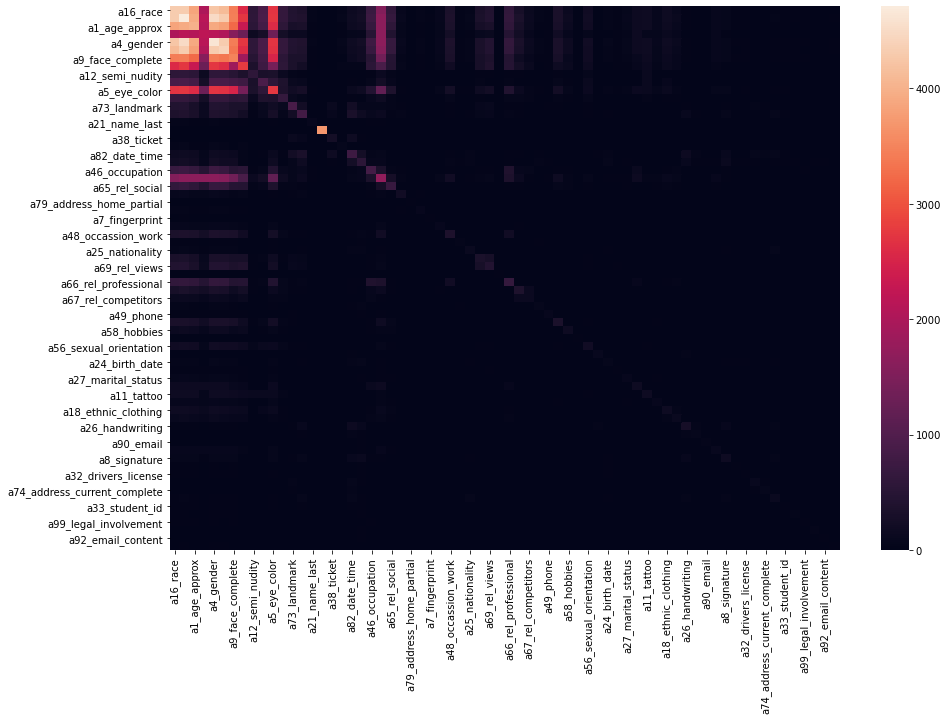

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.heatmap(co_matrix);

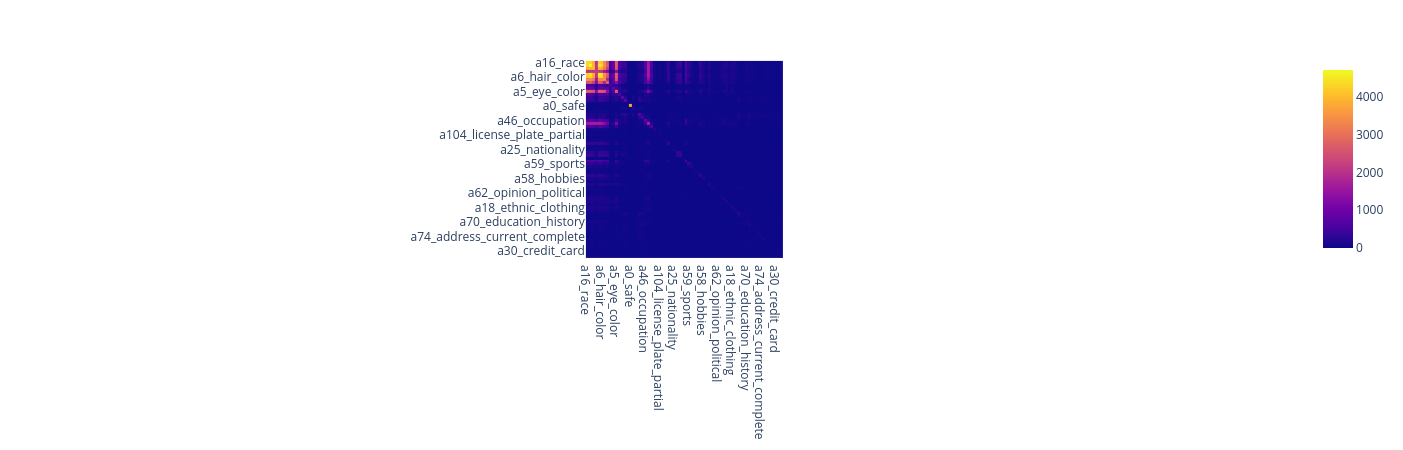

In [18]:
fig = px.imshow(co_matrix)
fig.show()